### Мой пилотник

In [ ]:
# Загрузка необходимых библиотек

import numpy as np

from sklearn.cluster import KMeans

import os                        # Модуль для работы с файлами операционной системы
import time                      # Модуль для работы со временем
import gdown                     # Модуль для загрузки больших файлов
import random                    # Модуль для генерации случайных значений
import matplotlib.pyplot as plt  # Модуль для работы с графиками и изображениями
import cv2
from PIL import Image            # Методы для работы с изображениями

%matplotlib inline

from sklearn.model_selection import train_test_split
from keras.optimizers import Adam                # Оптимизатор Adam
from keras.utils.vis_utils import plot_model     # метод для отрисовки модели
from tensorflow.keras.models import Sequential, Model
from tensorflow import keras
import tensorflow as tf          # Библиотека TensorFlow
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras import utils               # Используем для to_categorical
from tensorflow.keras.preprocessing import image # Для отрисовки изображений
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping

# Для загрузки своих изображений
from google.colab import files
from google.colab import drive

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# подключаем свой виртуальный диск
drive.mount('/content/drive')

Mounted at /content/drive


### Подготовка данных x y

In [ ]:
import zipfile

# Задаем  путь к архиву в скаринками
zip_file = '/content/drive/MyDrive/Diplom/x-ray_pneumo.zip'

# Распаковываем архив
zip_extract = zipfile.ZipFile(zip_file, 'r')
zip_extract.extractall()

# Проверяем результат разархивации
print(os.listdir())

['.config', 'drive', 'x-ray_pneumo', 'sample_data']


In [ ]:
# Переместим данные в директорию content для удобной работы
!cp -r /content/drive/MyDrive/Diplom/train /content

In [ ]:
IMAGE_PATH = '/content/x-ray_pneumo/train'

In [ ]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 2, метки классов: ['NORMAL', 'PNEUMONIA']


In [ ]:
# Формируем список путей и меток

data_files = []                           # Cписок путей к файлам картинок
data_labels = []                          # Список меток классов, соответствующих файлам

for class_label in range(CLASS_COUNT):    # Для всех классов по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен
    class_path = IMAGE_PATH + '/' + class_name  # Формирование полного пути к папке с изображениями класса
    class_files = os.listdir(class_path)  # Получение списка имен файлов с изображениями текущего класса
    print(f'Размер класса {class_name} составляет {len(class_files)} изображений')

    # Добавление к общему списку всех файлов класса с добавлением родительского пути
    data_files += [f'{class_path}/{file_name}' for file_name in class_files]

    # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
    data_labels += [class_label] * len(class_files)

print('Общий размер базы для обучения:', len(data_labels))

Размер класса NORMAL составляет 1341 изображений
Размер класса PNEUMONIA составляет 3875 изображений
Общий размер базы для обучения: 5216


In [ ]:
print(data_files[5000])

/content/x-ray_pneumo/train/PNEUMONIA/person25_bacteria_120.jpeg


In [ ]:
print(data_labels[5000])

1


In [ ]:
# Задаем высоту и ширину изображений
IMG_WIDTH = 24                           # Ширина изображения
IMG_HEIGHT = 42                           # Высота изображения

(42, 24)


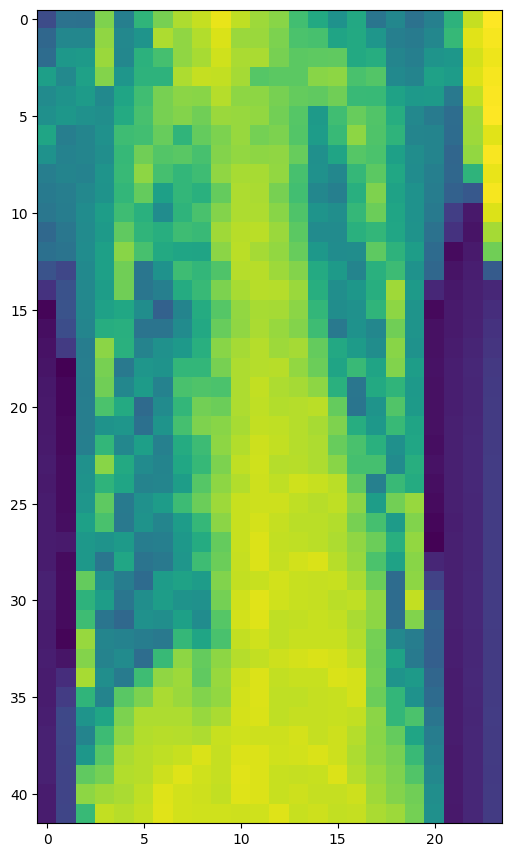

In [ ]:
one_image = data_files[5000]

img_one = cv2.imread(one_image)
img_one = cv2.cvtColor(img_one, cv2.COLOR_BGR2GRAY)
img_one = cv2.resize(img_one, (IMG_WIDTH, IMG_HEIGHT))
img_one_np = np.array(img_one)                # Перевод в numpy-массив
print(img_one_np.shape)

plt.figure(figsize=(6, 12))
plt.imshow(img_one_np)
plt.show()

In [ ]:
data_images = []                          # Пустой список для данных изображений

for file_name in data_files:
    # Открытие и смена размера изображения
    img = cv2.imread(file_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img.astype('float32')/255.0
    img_np = np.array(img)                # Перевод в numpy-массив
    data_images.append(img_np)            # Добавление изображения в виде numpy-массива к общему списку

x_data = np.array(data_images)            # Перевод общего списка изображений в numpy-массив
y_data = np.array(data_labels)            # Перевод общего списка меток класса в numpy-массив

print(f'В массив собрано {len(data_images)} фотографий следующей формы: {img_np.shape}')
print(f'Общий массив данных изображений следующей формы: {x_data.shape}')
print(f'Общий массив меток классов следующей формы: {y_data.shape}')

В массив собрано 5216 фотографий следующей формы: (42, 24)
Общий массив данных изображений следующей формы: (5216, 42, 24)
Общий массив меток классов следующей формы: (5216,)


In [ ]:
from sklearn.model_selection import train_test_split

# Делим данные на обучающую и проверочную выборки
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    shuffle=True,
                                                    test_size=0.05,
                                                    random_state=42)

# В нашем случае категории 0 и 1 в перевод one hot encoding не нуждаются
#from tensorflow.keras import utils               # Используем для to_categorical
## Превращаем выходы сетей в формат  one hot encoding
#y_train = utils.to_categorical(y_train, CLASS_COUNT)
#y_test = utils.to_categorical(y_test, CLASS_COUNT)

In [ ]:
# Решейпим

pic_shapes = x_train[0].shape
IMG_WIDTH = pic_shapes[0]
IMG_HEIGHT = pic_shapes[1]

# Делаем решейп
x_train = x_train.reshape(x_train.shape[0], IMG_WIDTH, IMG_HEIGHT)
x_test = x_test.reshape(x_test.shape[0],IMG_WIDTH, IMG_HEIGHT)

In [ ]:
# Проверяем размерности массивов

print(x_train.shape)
print(y_train.shape)
print()
print(x_test.shape)
print(y_test.shape)

(4955, 42, 24)
(4955,)

(261, 42, 24)
(261,)


In [ ]:
# Создаем директорию на диске для загрузки массивов
!mkdir /content/drive/MyDrive/Diplom/Data_2cat_42x64

In [ ]:
# Сохраняем наши массивы на диск

np.save('/content/drive/MyDrive/Diplom/Data_2cat_42x64/x_train.npy', x_train)
np.save('/content/drive/MyDrive/Diplom/Data_2cat_42x64/y_train.npy', y_train)
np.save('/content/drive/MyDrive/Diplom/Data_2cat_42x64/x_test.npy', x_test)
np.save('/content/drive/MyDrive/Diplom/Data_2cat_42x64/y_test.npy', y_test)

print('Массивы сохранены')

Массивы сохранены


### Обучение модели

Копируем данные в среду выполнения

In [ ]:
# Загружаем наши массивы из диска

x_train = np.load('/content/drive/MyDrive/Diplom/Data_2cat_42x64/x_train.npy')
y_train = np.load('/content/drive/MyDrive/Diplom/Data_2cat_42x64/y_train.npy')
x_test = np.load('/content/drive/MyDrive/Diplom/Data_2cat_42x64/x_test.npy')
y_test = np.load('/content/drive/MyDrive/Diplom/Data_2cat_42x64/y_test.npy')

In [ ]:
print(y_train[0])

1


In [ ]:
batch_size = 42

In [ ]:
# Создание модели последовательной архитектуры
model_notAuto = Sequential()

model_notAuto.add(Conv2D(256, (3, 3), padding='same', activation='relu', input_shape=(42, 24, 1)))
model_notAuto.add(BatchNormalization())

model_notAuto.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model_notAuto.add(MaxPooling2D(pool_size=(2, 2)))

model_notAuto.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model_notAuto.add(Dropout(0.2))

model_notAuto.add(Flatten())
model_notAuto.add(Dense(512, activation='relu'))
model_notAuto.add(Dense(CLASS_COUNT, activation='softmax'))

# Компиляция модели
model_notAuto.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 42, 24, 256)       2560      
                                                                 
 batch_normalization (BatchN  (None, 42, 24, 256)      1024      
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 24, 256)       590080    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 12, 256)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 12, 256)       590080    
                                                                 
 dropout (Dropout)           (None, 21, 12, 256)       0

In [ ]:
# Компиляция модели
model_notAuto.compile(loss='sparse_categorical_crossentropy',
                      optimizer=Adam(learning_rate=0.001),
                      metrics=['accuracy'])

In [ ]:
# Обучение модели сверточной нейронной сети подготовленных данных на 20-ти эпохах

store_learning = model_notAuto.fit(x_train,y_train,
                                   validation_split=0.1,
                                   batch_size=batch_size,
                                   epochs=20,
                                   verbose=1)

# Сохраним модель на диске
model_notAuto.save( '/content/drive/MyDrive/Diplom/model_x-ray_my.h5' )
model_notAuto.save_weights( '/content/drive/MyDrive/Diplom/model_x-ray_my_weights.h5' )

Epoch 1/20
107/107 [==============================] - 563s 5s/step - loss: 0.0412 - accuracy: 0.9830 - val_loss: 0.0802 - val_accuracy: 0.9819
Epoch 2/20
107/107 [==============================] - 570s 5s/step - loss: 0.0389 - accuracy: 0.9856 - val_loss: 0.1675 - val_accuracy: 0.9516
Epoch 3/20
107/107 [==============================] - 569s 5s/step - loss: 0.0397 - accuracy: 0.9854 - val_loss: 0.1581 - val_accuracy: 0.9677
Epoch 4/20
107/107 [==============================] - 568s 5s/step - loss: 0.0299 - accuracy: 0.9865 - val_loss: 0.1584 - val_accuracy: 0.9677
Epoch 5/20
107/107 [==============================] - 566s 5s/step - loss: 0.0248 - accuracy: 0.9908 - val_loss: 0.0984 - val_accuracy: 0.9718
Epoch 6/20
107/107 [==============================] - 567s 5s/step - loss: 0.0201 - accuracy: 0.9919 - val_loss: 0.1177 - val_accuracy: 0.9718
Epoch 7/20
107/107 [==============================] - 561s 5s/step - loss: 0.0298 - accuracy: 0.9890 - val_loss: 0.1220 - val_accuracy: 0.9718

In [ ]:
scores = model_notAuto.evaluate(x_test, y_test, verbose=1)
print(scores)
print(f"Доля верных ответов на тестовых данных в процентах: {round(scores[1],2) * 100} %")

9/9 [==============================] - 16s 2s/step - loss: 0.1916 - accuracy: 0.9732
[0.191614031791687, 0.9731800556182861]
Доля верных ответов на тестовых данных в процентах: 97.0 %


In [ ]:
# Сохраним модель на диске
model_notAuto.save( '/content/drive/MyDrive/Diplom/model_x-ray_my_best.h5' )
model_notAuto.save_weights( '/content/drive/MyDrive/Diplom/model_x-ray_my_weights_best.h5' )

In [ ]:
# Функция вывода графика обучения

def plot_graph(train_acc, val_acc, train_loss, val_loss):
  # Создание полотна для рисунка
  plt.figure(1, figsize=(18, 5))

  # Задание первой (левой) области для построения графиков
  plt.subplot(1, 2, 1)
  # Отрисовка графиков 'loss' и 'val_loss' из значений словаря store_learning.history
  plt.plot(train_loss, label='Значение ошибки на обучающем наборе')
  plt.plot(val_loss, label='Значение ошибки на проверочном наборе')
  # Задание подписей осей
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Значение ошибки')
  plt.legend()

  # Задание второй (правой) области для построения графиков
  plt.subplot(1, 2, 2)
  # Отрисовка графиков 'accuracy' и 'val_accuracy' из значений словаря store_learning.history
  plt.plot(train_acc, label='Доля верных ответов на обучающем наборе')
  plt.plot(val_acc, label='Доля верных ответов на проверочном наборе')
  # Задание подписей осей
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.legend()

  # Фиксация графиков и рисование всей картинки
  plt.show()

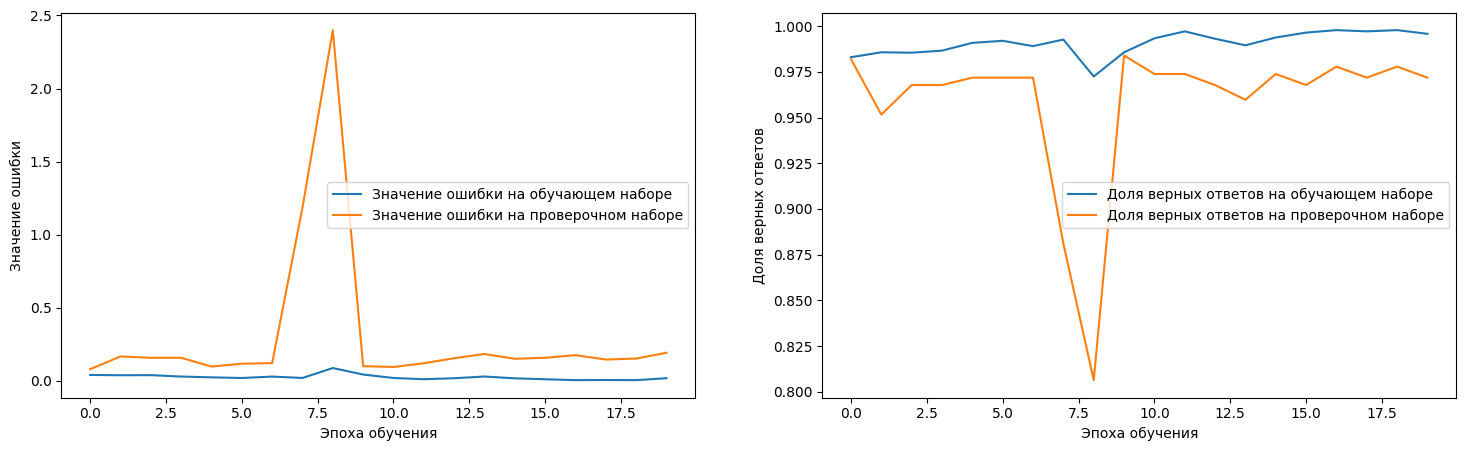

In [ ]:
# Выведем графики точности и ошибки:
plot_graph(store_learning.history['accuracy'],
           store_learning.history['val_accuracy'],
           store_learning.history['loss'],
           store_learning.history['val_loss'])

### Проверяем нашу модель

Подготавливаем рандомные тестовые данные из совершенно отдельной выборки для распознавания

Вспомогательные функции

Пройдемся проверкой нашей модели по отдельным файлам изображений

In [ ]:
# Создадим функцию итерации файлов в директории

def iterable_path(folder_path):
  '''
  функция перебора файлов в директории
  передаем только путь к директории
  '''
  iter_path = []
  for root, dirs, files in os.walk(folder_path):
    for file_name in files:
      file_path = os.path.join(root, file_name)
      iter_path.append(file_path)
  return iter_path

In [ ]:

def predict_tests(test_path, model, prediction_true = 1, IMG_WIDTH = 24, IMG_HEIGHT = 42):
  '''
  Функция предсказывает отношение изображения по пути к файлу
  в параметры передаются
  test_path - путь к изображению
  model - обученная модель
  prediction_true - 1-если в дериктории изображения с пневмонией 0-если изображения без пневмонии
  IMG_WIDTH, IMG_HEIGHT - ширина и высота изображения по умолчанию 24 на 42
  '''
  img = cv2.imread(test_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
  img = img.astype('float32')/255.0               # нормируем
  img_np = np.array(img)                          # Перевод в numpy-массив

  input_image = np.expand_dims(img_np, axis=0)    # Добавляем размерность

  prediction = model.predict(input_image, verbose=0)
  predicted_class = np.argmax(prediction[0])
  if predicted_class == prediction_true:
    variant = 'модель предсказала правильно'
  else:
    variant = 'модель предсказала не правильно'

  return f'{predicted_class} --- {variant}'

In [ ]:
test_path = '/content/x-ray_pneumo/test/PNEUMONIA/person101_bacteria_486.jpeg'

In [ ]:
predict_tests(test_path, model_notAuto, prediction_true=1, IMG_WIDTH = 24, IMG_HEIGHT = 42)

'1 --- модель предсказала правильно'

In [ ]:
test_path = '/content/x-ray_pneumo/test/PNEUMONIA/person10_virus_35.jpeg'
predict_tests(test_path, model_notAuto, prediction_true=1, IMG_WIDTH = 24, IMG_HEIGHT = 42)

'1 --- модель предсказала правильно'

In [ ]:
test_path = '/content/x-ray_pneumo/test/NORMAL/IM-0023-0001.jpeg'
predict_tests(test_path, model_notAuto, prediction_true=0, IMG_WIDTH = 24, IMG_HEIGHT = 42)

'1 --- модель предсказала не правильно'

In [ ]:
test_path = '/content/x-ray_pneumo/test/NORMAL/NORMAL2-IM-0030-0001.jpeg'
predict_tests(test_path, model_notAuto, prediction_true=0, IMG_WIDTH = 24, IMG_HEIGHT = 42)

'0 --- модель предсказала правильно'

Как видим модель ошиблась на выборке со снимком не пораженных легких

Давайте взглянем на эти снимки

In [ ]:
# Создадим функцию отрисовки снимка

def plot_image(path):
  img_one = cv2.imread(path)
  img_one_np = np.array(img_one)                # Перевод в numpy-массив
  print(img_one_np.shape)

  plt.figure(figsize=(6, 12))
  plt.imshow(img_one_np)
  plt.show()

In [ ]:
# Со снимком по пути path1 модель ошиблась, а со снимком path2 справилась

path1 = '/content/x-ray_pneumo/test/NORMAL/IM-0023-0001.jpeg'
path2 = '/content/x-ray_pneumo/test/NORMAL/NORMAL2-IM-0030-0001.jpeg'

path3 = '/content/x-ray_pneumo/test/PNEUMONIA/person24_virus_58.jpeg'    # снимок пораженного легкого

(1384, 2022, 3)


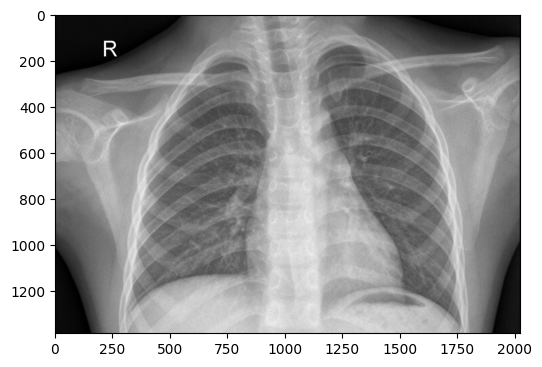

(792, 1352, 3)


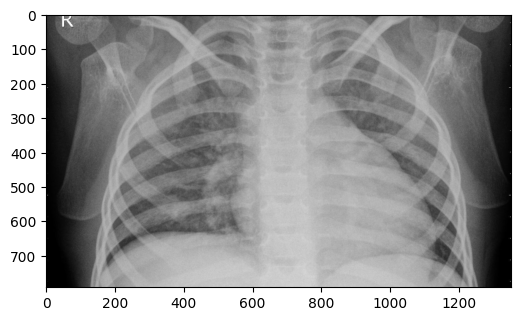

(2713, 2517, 3)


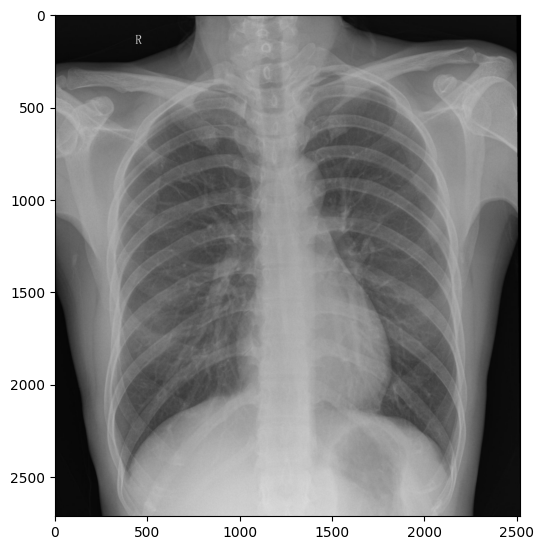

In [ ]:
plot_image(path1)   # снимок на котором ошиблась
plot_image(path3)   # снимок с поражением
plot_image(path2)   # снимок предсказала правильно

Пройдемся проверкой нашей модели по директориям с изображениями

In [ ]:
# Создадим функцию предсказания изображений из директории

def predict_test(test_path, model, IMG_WIDTH = 24, IMG_HEIGHT = 42):
  '''
  Функция предсказывает отношение изображения из дериктории
  в параметры передаются
  test_path - путь к папке с изображениями
  model - обученная модель
  IMG_WIDTH, IMG_HEIGHT - ширина и высота изображения по умолчанию 24 на 42

  Возвращаем список предсказаний
  '''
  pred_list = []
  iter_path = iterable_path(test_path)
  for i in iter_path:
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img.astype('float32')/255.0
    img_np = np.array(img)                # Перевод в numpy-массив

    input_image = np.expand_dims(img_np, axis=0)

    prediction = model.predict(input_image, verbose=0)
    predicted_class = np.argmax(prediction[0])
    pred_list.append(predicted_class)

  return pred_list

Проверим изображения из папки с изображением не поврежденных легких

In [ ]:
TEST_PATH = '/content/x-ray_pneumo/test/NORMAL'

pred_list_not_auto = predict_test(TEST_PATH, model_notAuto, IMG_WIDTH = 24, IMG_HEIGHT = 42)

In [ ]:
# предсказываем нашей моделью изображения из дериктории не поврежденных легких
for pred in pred_list_not_auto:
  if pred == 0:
    text = 'это правильное предсказание'
  else:
    text = 'это не правильное предсказание'
  print(f'Predicted class MyModel: {pred} ------  {text}')

Predicted class MyModel: 0 ------  это правильное предсказание
Predicted class MyModel: 1 ------  это не правильное предсказание
Predicted class MyModel: 0 ------  это правильное предсказание
Predicted class MyModel: 1 ------  это не правильное предсказание
Predicted class MyModel: 1 ------  это не правильное предсказание
Predicted class MyModel: 1 ------  это не правильное предсказание
Predicted class MyModel: 0 ------  это правильное предсказание
Predicted class MyModel: 0 ------  это правильное предсказание
Predicted class MyModel: 1 ------  это не правильное предсказание
Predicted class MyModel: 1 ------  это не правильное предсказание
Predicted class MyModel: 0 ------  это правильное предсказание
Predicted class MyModel: 0 ------  это правильное предсказание
Predicted class MyModel: 1 ------  это не правильное предсказание
Predicted class MyModel: 1 ------  это не правильное предсказание
Predicted class MyModel: 1 ------  это не правильное предсказание
Predicted class MyModel: 1 -

Проверим изображения из папки с изображением пневмонии

In [ ]:
TEST_PATH = '/content/x-ray_pneumo/test/PNEUMONIA'

pred_list_not_auto = predict_test(TEST_PATH, model_notAuto, IMG_WIDTH = 24, IMG_HEIGHT = 42)

In [ ]:
# предсказываем моделью автокераса изображения из дериктории пневмония
for pred in pred_list_not_auto:
  if pred == 1:
    text = 'это правильное предсказание'
  else:
    text = 'это не правильное предсказание'
  print(f'Predicted class MyModel: {pred} ------  {text}')

Predicted class MyModel: 1 ------  это правильное предсказание
Predicted class MyModel: 1 ------  это правильное предсказание
Predicted class MyModel: 1 ------  это правильное предсказание
Predicted class MyModel: 1 ------  это правильное предсказание
Predicted class MyModel: 1 ------  это правильное предсказание
Predicted class MyModel: 1 ------  это правильное предсказание
Predicted class MyModel: 1 ------  это правильное предсказание
Predicted class MyModel: 1 ------  это правильное предсказание
Predicted class MyModel: 1 ------  это правильное предсказание
Predicted class MyModel: 1 ------  это правильное предсказание
Predicted class MyModel: 1 ------  это правильное предсказание
Predicted class MyModel: 1 ------  это правильное предсказание
Predicted class MyModel: 1 ------  это правильное предсказание
Predicted class MyModel: 1 ------  это правильное предсказание
Predicted class MyModel: 1 ------  это правильное предсказание
Predicted class MyModel: 1 ------  это правильное предс

Как мы видим модель ошибается больше на снимках с нормальными легкими, можно предположить что это связанно с тем что очень тонкая грань в определении пораженных и не пораженных легких по снимкам, и это зависит от пограничного состояния с пневмонией, например курение либо простуда. Именно на таких снимках, по наблюдению, возникают ошибки и погрешности.

### Развитие модели по предсказанию а именно кластеризация данных

In [ ]:
# Отобразим размерность нашего массива
x_train.shape

(4955, 42, 24)

In [ ]:
# Для подачи обучения в модель кластеризации сделаем решейп размерности
x_train_resh = x_train.reshape(4955, 1008)

In [ ]:
print(x_train_resh.shape)

(4955, 1008)


In [ ]:
# Разделим наш датасет на 4 кластера
kmeans = KMeans(n_clusters=4)
kmeans.fit(x_train_resh)
labels = kmeans.labels_

In [ ]:
print(labels)

[2 0 0 ... 0 1 3]


In [ ]:
# Импорт метрики качества кластеризации
from sklearn.metrics.cluster import adjusted_rand_score

# Результат кластеризации
predictions = kmeans.predict(x_train_resh)

# Оценка качества кластеризации с помощью метрики ARI
adjusted_rand_score(predictions, labels)

1.0

(4955, 2) (4955,)


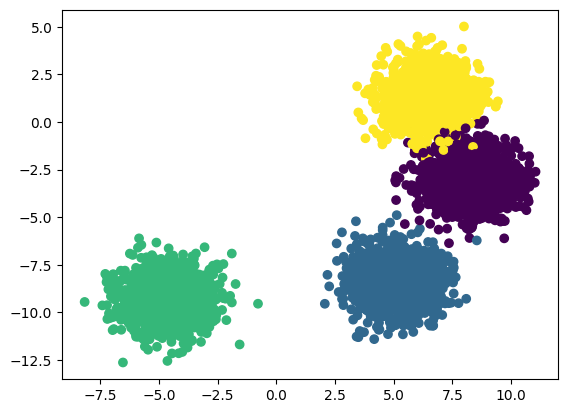

In [ ]:
# Посмотрим график распределения по кластерам

from sklearn.datasets import make_blobs
# Генерируем размерность двумерных точек равный размерности массива, разбитых на 4 кластера
# (X - координаты точек, y - метки принадлежности к кластерам)
X, y = make_blobs(n_samples=x_train.shape[0], centers=4, n_features=2)
print(X.shape, y.shape)                                   # Выводим размерность получившегося массива
plt.scatter(X[:, 0], X[:, 1], c=y)                        # Выводим точки на график с разбивкой точек по цвету
plt.show()

In [ ]:
def predict_clasterization(test_path, model_clasterization, IMG_WIDTH = 24, IMG_HEIGHT = 42):
  '''
  Функция предсказывает стадию поражения по пути к файлу
  в параметры передаются
  test_path - путь к изображению
  model_clasterization - обученная модель кластеризации
  IMG_WIDTH, IMG_HEIGHT - ширина и высота изображения по умолчанию 24 на 42
  '''
  img = cv2.imread(test_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
  img = img.astype('float32')/255.0               # нормируем
  img_np = np.array(img)                          # Перевод в numpy-массив
  img_np_resh = img_np.reshape(1008)

  input_image = np.expand_dims(img_np_resh, axis=0)    # Добавляем размерность

  predictions_one = model_clasterization.predict(input_image)

  if predictions_one == 0:
    variant = 'Четвертая стадия пневмонии'
  elif predictions_one == 1:
    variant = 'Третья стадия пневмонии'
  elif predictions_one == 2:
    variant = 'Вторая стадия пневмонии'
  else:
    variant = 'Первая стадия пневмонии'

  return f'{predictions_one} --- {variant}'

In [ ]:
test_path_claster = '/content/x-ray_pneumo/test/PNEUMONIA/person121_bacteria_576.jpeg'

predict_clasterization(test_path_claster, kmeans, IMG_WIDTH = 24, IMG_HEIGHT = 42)

'[3] --- Первая стадия пневмонии'

(584, 1088, 3)


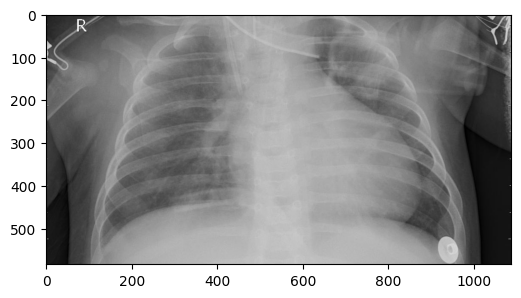

In [ ]:
plot_image(test_path_claster)

In [ ]:
test_path_claster1 = '/content/x-ray_pneumo/test/PNEUMONIA/person126_bacteria_599.jpeg'

predict_clasterization(test_path_claster1, kmeans, IMG_WIDTH = 24, IMG_HEIGHT = 42)

'[0] --- Четвертая стадия пневмонии'

(592, 856, 3)


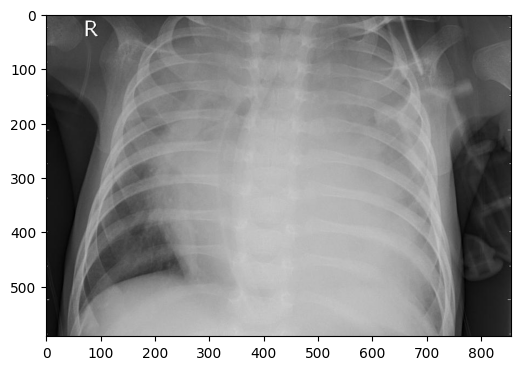

In [ ]:
plot_image(test_path_claster1)

In [ ]:
test_path_claster2 = '/content/x-ray_pneumo/test/PNEUMONIA/person100_bacteria_479.jpeg'

predict_clasterization(test_path_claster2, kmeans, IMG_WIDTH = 24, IMG_HEIGHT = 42)

'[1] --- Третья стадия пневмонии'

(552, 904, 3)


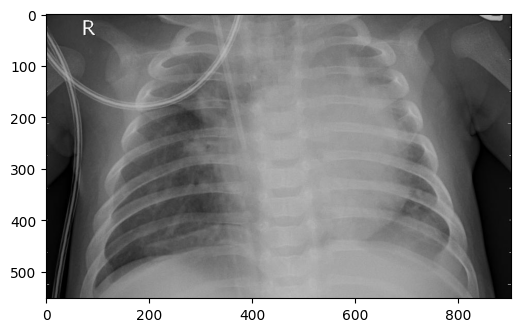

In [ ]:
plot_image(test_path_claster2)

In [ ]:
test_path_claster3 = '/content/x-ray_pneumo/test/PNEUMONIA/person101_bacteria_483.jpeg'

predict_clasterization(test_path_claster3, kmeans, IMG_WIDTH = 24, IMG_HEIGHT = 42)

'[2] --- Вторая стадия пневмонии'

(720, 1064, 3)


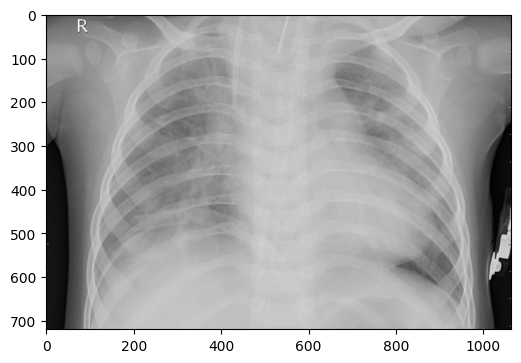

In [ ]:
plot_image(test_path_claster3)

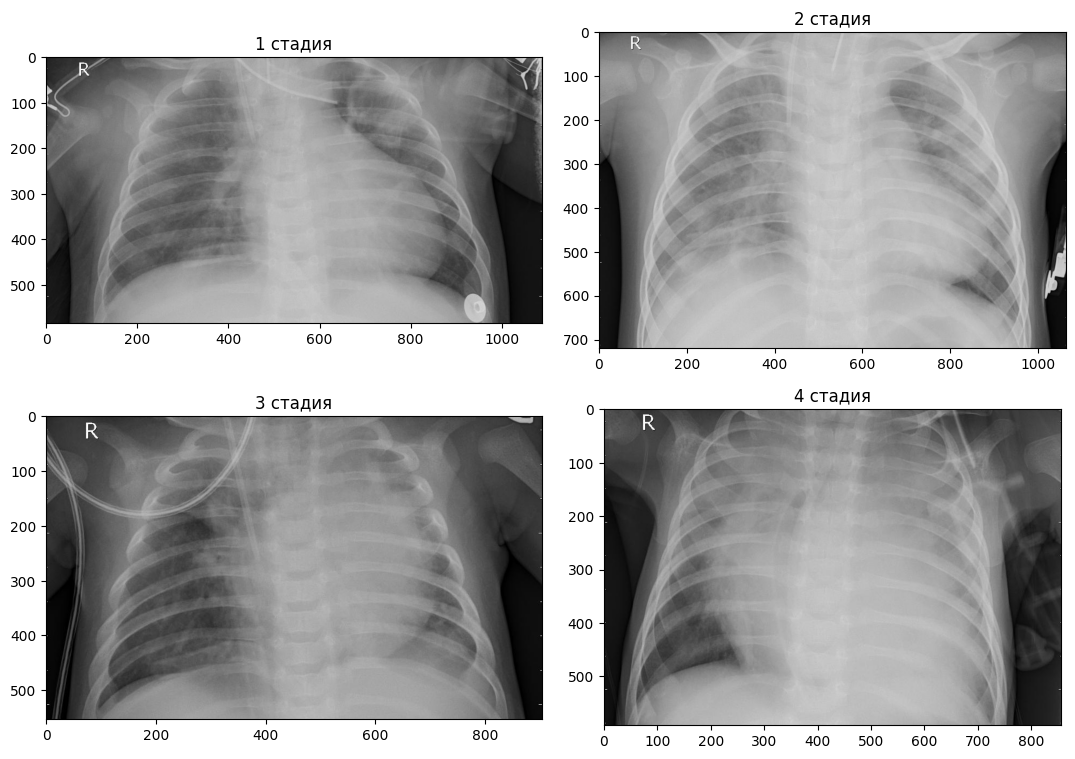

In [ ]:
# Создадим словарь путей к файлам приведенным выше по порядку согласно стадиям поражения

image_path_claster = [test_path_claster, test_path_claster3, test_path_claster2, test_path_claster1]

plt.figure(figsize=(11, 15))

for i, path in enumerate(image_path_claster):

    # открываем первое изображение
    img = cv2.imread(path)

    # отображаем его
    plt.subplot(4, 2, i + 1)
    plt.title(f'{i+1} стадия')
    plt.imshow(img)

plt.tight_layout()
plt.show()

(1827, 2271, 3)


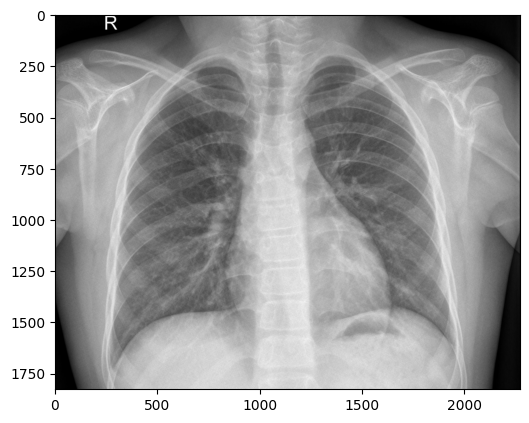

In [ ]:
# Для сравнения снимок нормальных легких
test_path_normal = '/content/x-ray_pneumo/test/NORMAL/IM-0027-0001.jpeg'

plot_image(test_path_normal)

In [ ]:
# Демонтируем наш GoogleDick
drive.flush_and_unmount()

### Выводы

Стадии пневмонии могут незначительно различатся в зависимости от причин и типа пневмонии. Также влияния на деффекты на снимках оказывают другие причины, такие как перенесенные заболевания легких, курение и прочее.

Дипломная работа на мой взгляд выполнила поставленные задачи по выявлению пневмонии по снимкам ренгена, и определение стадии поражения легких. Добились accuracy на тестовой выборке порядка 97%, оценку качества кластеризации с помощью метрики ARI 100%.

Как мы видим по отображению стадий поражения легких пневмонией у нас получилось первое приближение, а может даже и рабочий вариант определения стадий поражения легких, а так же непосредственно само наличие поражения легких пневмонией

### Дальнейшая работа над проектом

далее запуск в продакшн

Для начала разместим проект в Git